In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
PATH = "/content/drive/MyDrive/NLP/"
f = open(PATH + "multiple_choice_92sim.json",)
data = json.load(f)

print(len(data))
f.close()

In [ ]:
import json
PATH = "/content/drive/MyDrive/Colab Notebooks/NLP/"
f = open(PATH + "multiple_choice_92sim.json",)
data = json.load(f)

print(len(data))
f.close()

3441


In [ ]:
import json
PATH = "/content/drive/MyDrive/Colab Notebooks/NLP/"
f = open(PATH + "SQ_pairs.json",)
data = json.load(f)

print(len(data))
f.close()

3586


In [ ]:
import json
PATH = "/content/drive/MyDrive/Colab Notebooks/NLP/"
f = open(PATH + "SQ_pairs.json",)
data = json.load(f)

print(len(data))
f.close()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# train_texts, test_texts = train_test_split(data, test_size=.1)
# with open(PATH + 'SQ_data/train.json', 'w') as f:
#   json.dump(train_texts, f)

# with open(PATH + 'SQ_data/test.json', 'w') as f:
#   json.dump(test_texts, f)

In [ ]:
DATAPATH = PATH + 'SQ_data/train.json'
def get_data(path=DATAPATH):

  question_list = list()
  expo_list = list()

  with open(DATAPATH) as f:
    data = list(json.load(f))
  
  for question, expo in data:
    question_list.append(question)
    expo_list.append(expo[0])

  return question_list, expo_list

In [ ]:
question_list, expo_list = get_data()

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.0MB 14.4MB/s 
     |████████████████████████████████| 3.2MB 26.7MB/s 
     |████████████████████████████████| 890kB 51.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=73cf1d6d12bda63e020daa83dd5fa0c5a2df2d1f130772718eae2f76b98ea989
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch
import transformers
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, length):
        self.encodings = encodings
        self.labels = labels
        self.length = length

    def __getitem__(self, idx):
        encoding_item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        label_item = {key: torch.tensor(val[idx]) for key, val in self.labels.items()}
        return encoding_item, label_item

    def __len__(self):
        return self.length

def get_dataset(question_list, expo_list):
    from sklearn.model_selection import train_test_split
    from transformers import BartTokenizerFast

    train_qs, val_qs, train_es, val_es = train_test_split(question_list, expo_list, test_size=.1)

    tokenizer = BartTokenizerFast.from_pretrained('facebook/bart-base')

    train_q_encodings = tokenizer(train_qs, truncation=True, padding=True)
    val_q_encodings = tokenizer(val_qs, truncation=True, padding=True)

    train_e_encodings = tokenizer(train_es, truncation=True, padding=True)
    val_e_encodings = tokenizer(val_es, truncation=True, padding=True)

    train_dataset = IMDbDataset(train_e_encodings,train_q_encodings, length = len(train_qs))
    val_dataset = IMDbDataset(val_e_encodings, val_q_encodings, length=len(val_qs))

    return train_dataset, val_dataset

In [ ]:
train_dataset, val_dataset = get_dataset(question_list, expo_list)

In [ ]:
print(len(train_dataset))

2904


In [ ]:
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss

from torch.utils.data import DataLoader
from transformers import BartForConditionalGeneration, AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model =  BartForConditionalGeneration.from_pretrained('facebook/bart-base')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

In [ ]:
WEIGHT_PATH = PATH + 'weights/bert'

In [ ]:
def train(epochs=10):
    train_loss_set = list()
    for epoch in range(epochs):
        for batch in train_loader:
            input, label = batch

            optim.zero_grad()

            input_ids = input['input_ids'].to(device)
            attention_mask = input['attention_mask'].to(device)

            labels = label['input_ids'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            # loss_func = BCEWithLogitsLoss()
            # loss = loss_func(logits, labels)  # convert labels to float for calculation
            # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
            train_loss_set.append(loss.item())

            # Backward pass
            loss.backward()

            optim.step()

        print("Finished epoch {}".format(epoch))

    model.save_pretrained(WEIGHT_PATH)
    return train_loss_set

Finished epoch 0
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5
Finished epoch 6
Finished epoch 7
Finished epoch 8
Finished epoch 9


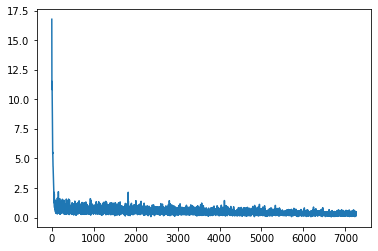

In [ ]:
loss_values = train(10)

import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.show()

In [ ]:
DATAPATH = PATH + 'SQ_data/test.json'
import torch
from transformers import BartTokenizerFast
tokenizer = BartTokenizerFast.from_pretrained('facebook/bart-base')
def get_data(path=DATAPATH):

  question_list = list()
  expo_list = list()

  with open(DATAPATH) as f:
    data = list(json.load(f))
  
  for question, expo in data:
    question_list.append(question)
    expo_list.append(expo[0])

  #return question_list[:10], expo_list[:10]
  return question_list, expo_list

class TestDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, expos, labels, length):
      self.encodings = encodings
      self.expos = expos
      self.labels = labels
      self.length = length

  def __getitem__(self, idx):
      encoding_item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      return (encoding_item, self.labels[idx], self.expos[idx])

  def __len__(self):
      return self.length

def get_dataset(question_list, expo_list):

  expo_encodings = tokenizer(expo_list, truncation=True, padding=True)

  test_dataset = TestDataset(expo_encodings, expo_list, question_list,length = len(question_list))

  return test_dataset

In [ ]:
question_list, expo_list = get_data()
test_dataset = get_dataset(question_list, expo_list)

In [ ]:
from transformers import BartForConditionalGeneration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from torch.utils.data import DataLoader

def validate(val_dataset):
    model =  BartForConditionalGeneration.from_pretrained(WEIGHT_PATH)
    model.to(device)
    model.eval()

    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

    print("Evaluating on {} questions".format(len(val_dataset)))

    list_of_references = list()
    list_of_hypotheses = list()
    list_of_original = list()

    for batch in val_loader:
        input, label, orig = batch
        input_ids = input['input_ids'].to(device)
        attention_mask = input['attention_mask'].to(device)

        with torch.no_grad():
            generated_sequences = model.generate(
                input_ids=input_ids,
                do_sample=True,
                max_length=200,
                temperature=1.0,
                top_k=5,
                top_p=0.9,
                repetition_penalty=1.0,
                )

            hypothesis = list()
            #print(label)
            reference = label[0].split()
          
            for sequence in generated_sequences:
                text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
                hypothesis = text.split()
                # Prints out sequences
                # print(text)
              
            #print(hypothesis)
            #print(orig)
            
            list_of_hypotheses.append(hypothesis)
            list_of_references.append([reference])
            list_of_original.append(orig)
            
            
    # Calculate BLEU Score
    import nltk
    score = nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses)
    return list_of_references, list_of_hypotheses,list_of_original, score
        
      # import torchtext
      #   score = torchtext.data.metrics.bleu_score(candidate_corpus, references_corpus)

In [ ]:
list_of_references, list_of_hypotheses, list_of_original, score = validate(test_dataset)

Evaluating on 359 questions


In [ ]:
print(score)

0.012088462422612701


In [ ]:
from pprint import pprint

In [ ]:
for i in range(len(list_of_references)):
  print("Original:")
  print(list_of_original[i])
  print("Ground Truth:")
  print(' '.join(list_of_references[i][0]))
  print("Generated: ")
  print(list_of_hypotheses[i])
  print("-------------------------------")

Original:
('Hey, guys. Thanks for taking my questions. And to Keith, Marc Benioff, thank you. Thank you for those comments. It was meaningful. I guess, I’d ask my two questions quickly. One is, you’ve seen acceleration now for a couple of quarters in Sales Cloud, Service Cloud accelerated despite the very, very healthy growth last year, Marketing Cloud on organic basis doing really well.',)
Ground Truth:
If you were to think about the breakout outside the cross-sell, meaning how are these clouds doing on their own?
Generated: 
['</s><s>', 'Can', 'you', 'talk', 'about', 'the', 'drivers', 'of', 'that', 'acceleration?', 'Are', 'there', 'any', 'particular', 'drivers', 'that', 'you’re', 'seeing', 'that’s', 'enabling', 'the', 'growth', 'there?</s>']
-------------------------------
Original:
("Thanks for the commentary on dealer inventory and otherwise. It seems like you made a positive step. And dealer inventories are going down, up last quarter, going down now; and yet that was only maybe a